In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import analysis

In [2]:
analyser = analysis.Analyser("ycsb")
all_data = analyser.get_data()
all_data

loading from ../bench/ycsb
processing fbc09f62f4d9c406dcdb1eff21784102c0f35713ef65443079c87dd468d022d7
processing 6aef12c8d926a45cc993b3a75eaa22b86fa425042e3fd0437e615acc7cf06b3c
processing 464842f941f67bb1d0a77f56faeab440773cb082e1f43003a274c06ba7332b94
processing dcfd5ca0f0d19c62665a4fbb45cf78ea281c4662f1c9f4d65889505cc1a4bc43
processing 3a30b4b5e593a614da8ee0c4804e2909ddd94c05167b690e0c942e7fb6fb3406
processing 60cdcf98b33f270474cec5cee3bfc4147f021db183380facf11f3dd5bd374355


,operation,start_ms,end_ms,latency_ms,store,tls,enclave,node_count,nodes,worker_threads,sig_tx_interval,sig_ms_interval,ledger_chunk_bytes,snapshot_tx_interval,http_version,workload,rate,threads
0,READ,0.016,34.556,34.540,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloadf,10000,1
1,READ,35.823,37.040,1.217,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloadf,10000,1
2,READ,38.224,39.427,1.203,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloadf,10000,1
3,READ,40.618,41.863,1.245,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloadf,10000,1
4,READ,41.869,43.082,1.213,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloadf,10000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,INSERT,57127.364,57128.643,1.279,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloade,10000,1
6992,INSERT,57802.952,57804.228,1.276,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloade,10000,1
6993,INSERT,58207.040,58208.414,1.374,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloade,10000,1
6994,INSERT,58208.466,58209.783,1.317,lskv,True,sgx,1,ssh://10.0.0.6:8000,0,5000,1000,5MB,10000,2,workloade,10000,1


In [3]:
ignore_vars = [
    "ledger_chunk_bytes",
    "snapshot_tx_interval",
    "sig_tx_interval",
    "sig_ms_interval",
    "nodes",
]

# All var plots

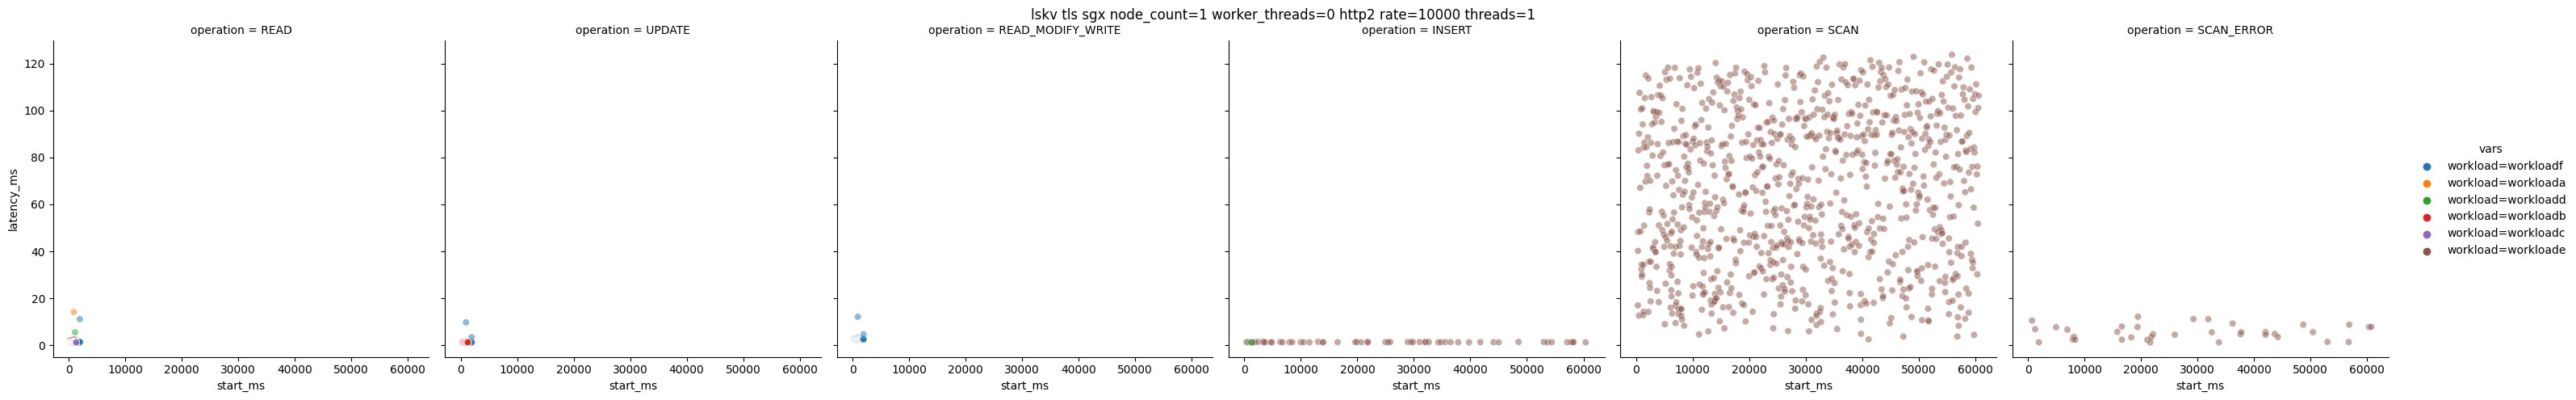

In [4]:
plot_data = all_data.copy(deep=False)
plot_data = plot_data[plot_data["start_ms"] > 250]
analyser.plot_scatter(plot_data, col="operation", ignore_vars=ignore_vars)

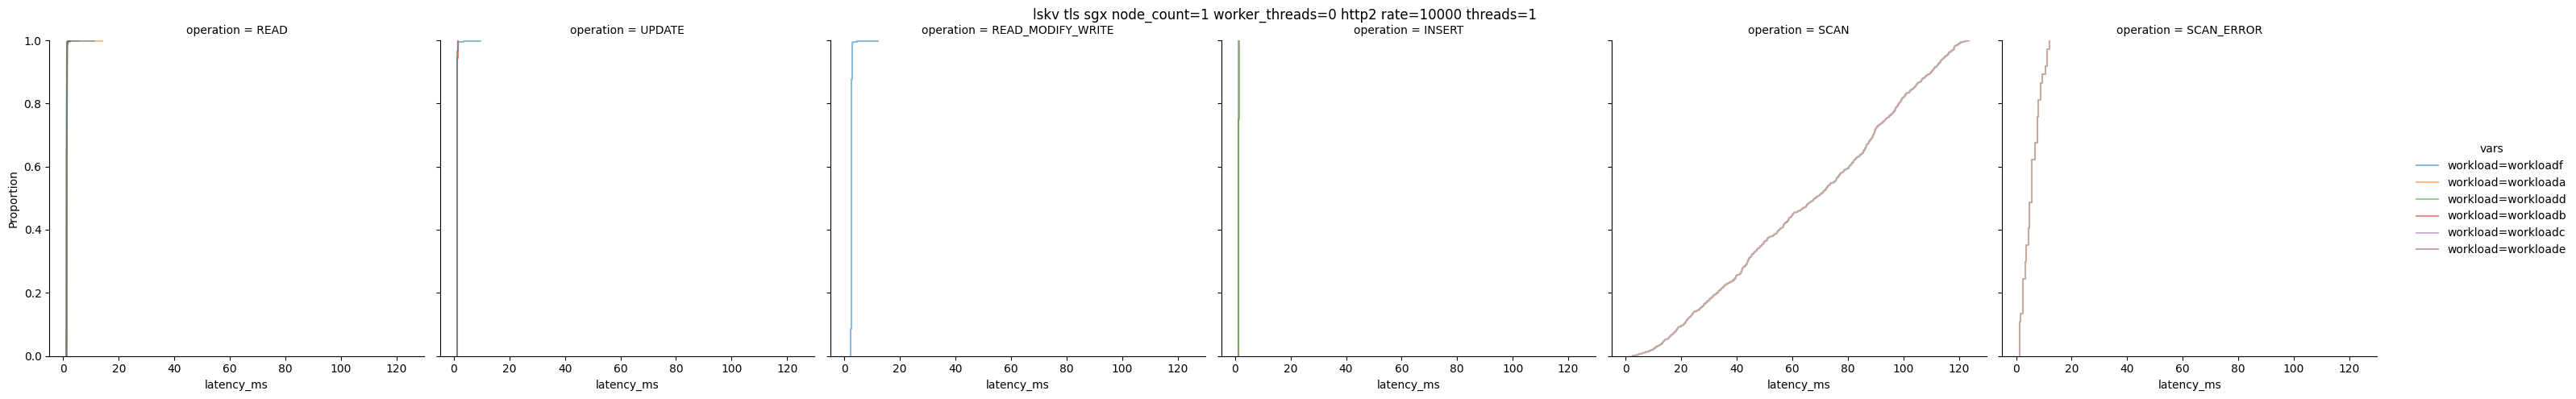

In [5]:
plot_data = all_data.copy(deep=False)
plot_data = plot_data[plot_data["start_ms"] > 250]
analyser.plot_ecdf(plot_data, col="operation", ignore_vars=ignore_vars)

/home/apj39/projects/LSKV/benchmark/analysis.py:495: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  latencies = grouped.quantile(percentile)


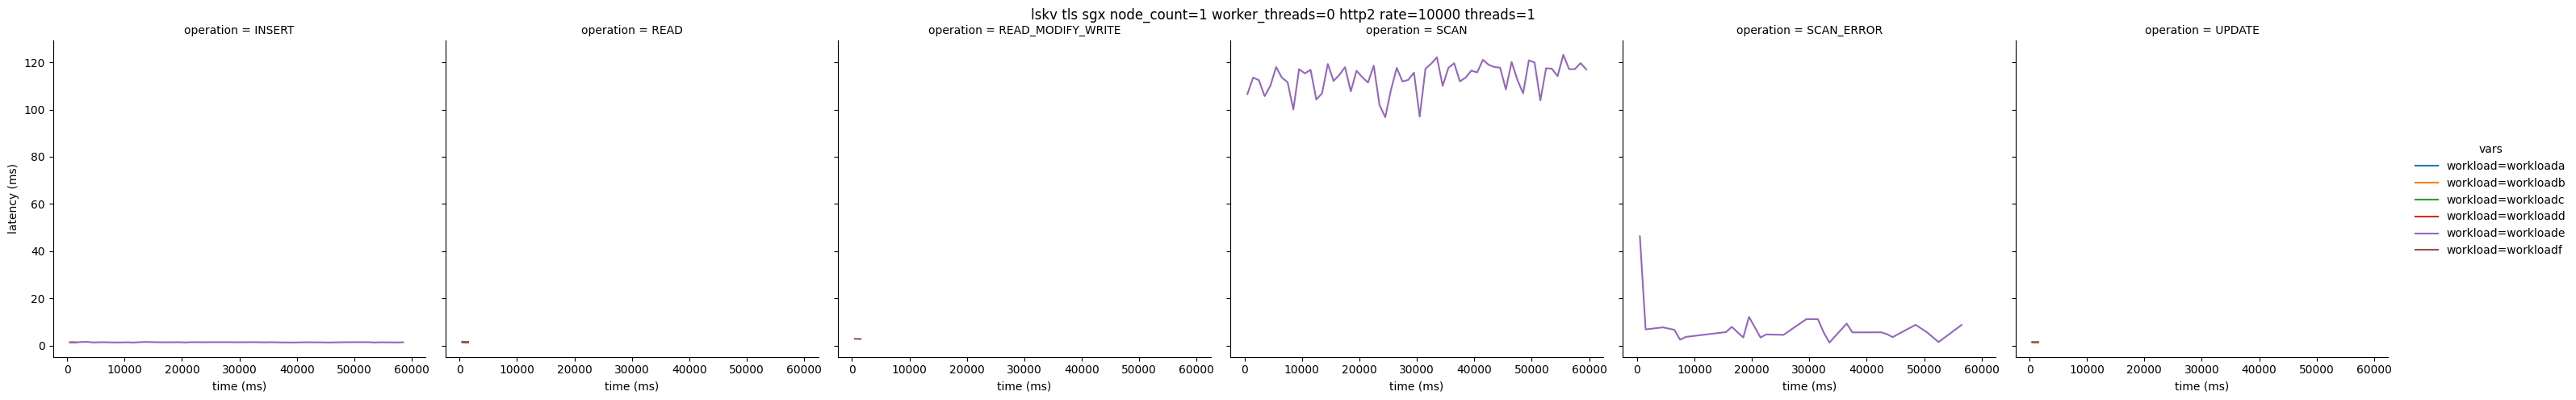

In [6]:
plot_data = all_data.copy(deep=False)
p = analyser.plot_percentile_latency_over_time(plot_data, col="operation", ignore_vars=ignore_vars)
p.set(xlabel="time (ms)", ylabel="latency (ms)")

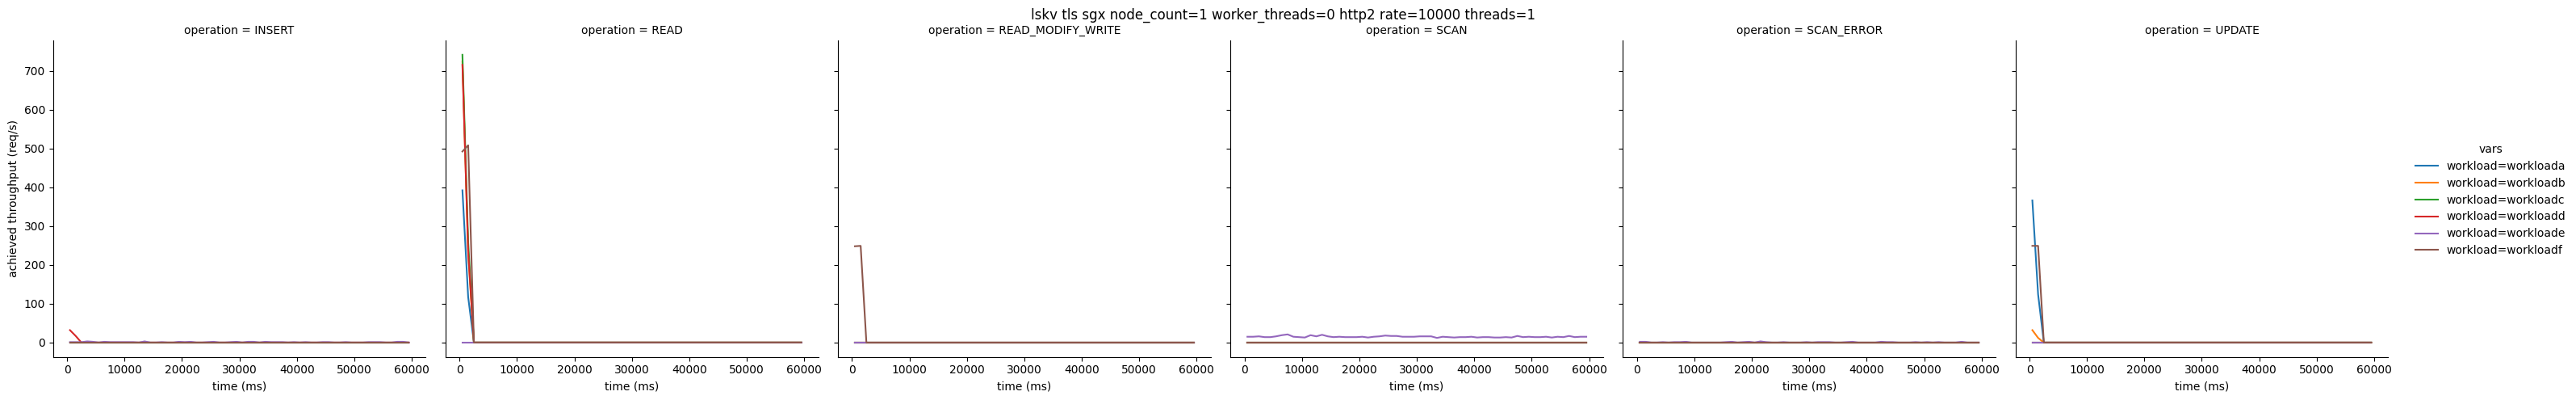

In [7]:
plot_data = all_data.copy(deep=False)
p = analyser.plot_throughput_over_time(plot_data, col="operation", ignore_vars=ignore_vars)
p.set(xlabel="time (ms)", ylabel="achieved throughput (req/s)")

# Workload comparison

In [8]:
def plot_latency_and_throughput(datasets, labels, ignore_vars):
    figure, axis = plt.subplots(2, 1, sharex=True)

    axis[0].grid(True)
    axis[1].grid(True)

    for dataset in datasets:
        # check that we don't have hidden variables grouped
        var, invariant_vars = analysis.condense_vars(dataset, ignore_vars)
        assert len(var) == 0, set(var)

    print("Invariants:", invariant_vars)

    def percentile_latencies(data):
        end = data["start_s"].max()
        group_cols = [pd.cut(data["start_s"], np.arange(0, end, interval))]
        grouped = data.groupby(group_cols)
        latencies = grouped.quantile(percentile, numeric_only=True)
        mid = latencies.index.map(lambda x: (x.left + x.right) // 2)
        latencies["mid"] = mid
        x = latencies["mid"]
        y = latencies["latency_ms"]
        return x, y

    def throughput_over_time(data):
        x = data["start_s"]
        end = data["start_s"].max()
        group_cols = [pd.cut(data["start_s"], np.arange(0, end, interval))]
        grouped = data.groupby(group_cols)
        throughputs = grouped.count() // interval
        mid = throughputs.index.map(lambda x: (x.left + x.right) // 2)
        throughputs["mid"] = mid
        x = throughputs["mid"]
        y = throughputs["latency_ms"]
        return x, y

    interval = 1
    percentile = 0.99

    for (dataset, label) in zip(datasets, labels):
        x, y = percentile_latencies(dataset)

        axis[0].plot(x, y, label=label)

    axis[0].legend()
    axis[0].set_ylabel("Request latency (ms)")

    for (dataset, label) in zip(datasets, labels):
        x, y = throughput_over_time(dataset)
        axis[1].plot(x, y, label=label)

    axis[1].legend()

    axis[1].set_xlabel("Time (s)")
    axis[1].set_ylabel("Achieved throughput (req/s)")

    return figure, axis

/tmp/ipykernel_197362/3388528543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["start_ms"] -= dataset["start_ms"].min()
/tmp/ipykernel_197362/3388528543.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["start_s"] = dataset["start_ms"] / 1000
/tmp/ipykernel_197362/3388528543.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Invariants: ['lskv', 'tls', 'sgx', 'node_count=1', 'worker_threads=0', 'http2', 'workload=workloadf', 'rate=10000', 'threads=1']


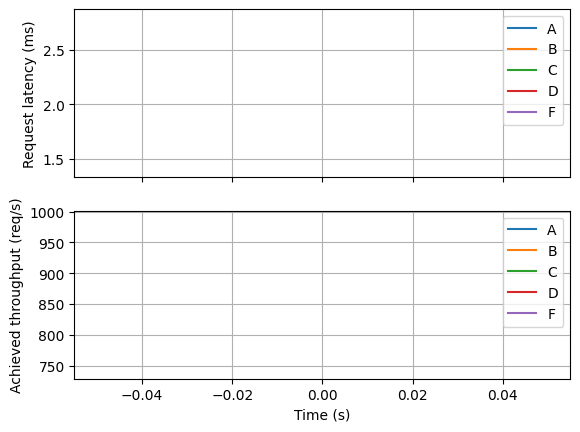

In [9]:
plot_data = all_data.copy(deep=False)

a_data = plot_data[plot_data["workload"] == "workloada"]
b_data = plot_data[plot_data["workload"] == "workloadb"]
c_data = plot_data[plot_data["workload"] == "workloadc"]
d_data = plot_data[plot_data["workload"] == "workloadd"]
# e_data = plot_data[plot_data["workload"] == "workloade"]
f_data = plot_data[plot_data["workload"] == "workloadf"]

datasets = [a_data, b_data, c_data, d_data, f_data]
for dataset in datasets:
    dataset["start_ms"] -= dataset["start_ms"].min()
    dataset["start_s"] = dataset["start_ms"] / 1000

fig, axes = plot_latency_and_throughput(
    datasets, ["A", "B", "C", "D", "F"], ignore_vars + ["start_s", "operation"]
)

fig.savefig("../plots/ycsb/final-workloads-comparison.png")


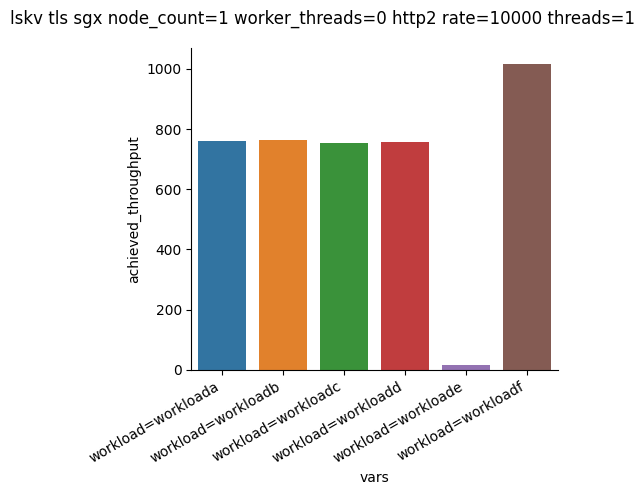

In [10]:
plot_data = all_data.copy(deep=False)
analyser.plot_achieved_throughput_bar(
    plot_data, ignore_vars=ignore_vars + ["operation"]
)

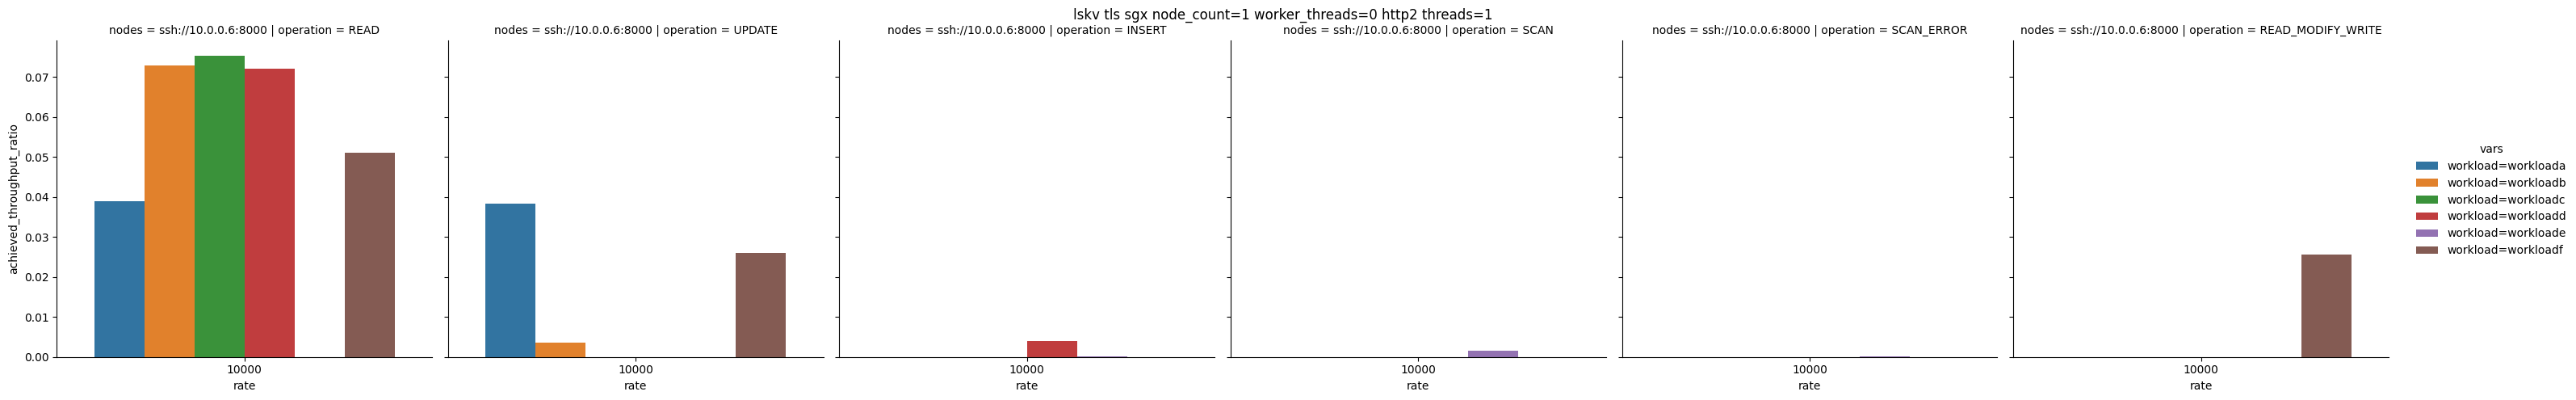

In [11]:
plot_data = all_data.copy(deep=False)
analyser.plot_throughput_bar(
    plot_data, row="nodes", col="operation", ignore_vars=ignore_vars
)

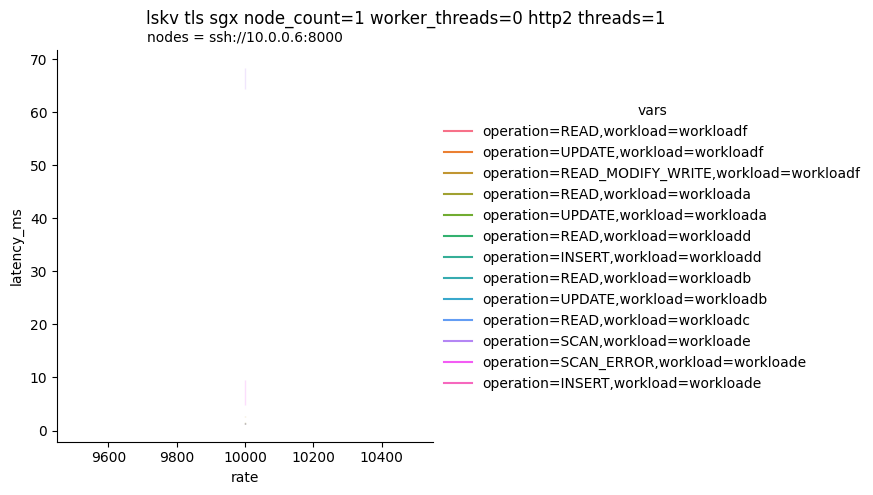

In [12]:
plot_data = all_data.copy(deep=False)
analyser.plot_target_throughput_latency_line(
    plot_data, col="nodes", ignore_vars=ignore_vars
)